<a href="https://colab.research.google.com/github/Rami-RK/image_segmentation/blob/main/Segmentation_Deeplabv3_plus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Semantic Image Segmentation using DeepLabV3+**

## Learning Objectives:

At the end of the experiment, you will be able to:

- understand, prepare, and visualize the the dataset containing image and corresponding masked image used for segmentation
- implement DeepLabV3+ architecture for Multi-class Semantic Segmentation
- create a masked image (prediction)
- calculate the accuracy score like IoU and Dice-Score used in segmentation


## Introduction

Semantic segmentation is a deep learning algorithm that associates a label or category with every pixel in an image. It is used to recognize a collection of pixels that form distinct categories. For example, an autonomous vehicle needs to identify vehicles, pedestrians, traffic signs, pavement, and other road features.

The below figure shows how semantic segmentation differs from other algorithms, such as object detection.

<br>
<img src='https://manipulation.csail.mit.edu/data/coco_instance_segmentation.jpeg' width=700px>
<br><br>

In this experiment, we implement the **DeepLabV3+** model for multi-class semantic segmentation, a fully-convolutional architecture that performs well on semantic segmentation benchmarks.

## Dataset

We will use the Crowd Instance-level Human Parsing ([CIHP](https://arxiv.org/abs/1811.12596)) Dataset for training our model. The entire dataset has 38,280 diverse human images.

Training on the entire CIHP dataset with 38,280 images takes a lot of time, hence we will be using a smaller subset of 1,000 images for training, 50 images for validation, and 50 images for testing purpose.

Each image in CIHP is labeled with pixel-wise annotations for 20 categories given below:

0. Background
1. Hat
2. Hair
3. Glove
4. Sunglasses
5. UpperClothes
6. Dress
7. Coat
8. Socks
9. Pants
10. Torso-skin
11. Scarf
12. Skirt
13. Face
14. Left-arm
15. Right-arm
16. Left-leg
17. Right-leg
18. Left-shoe
19. Right-shoe

### Import required packages

In [3]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [1]:
#@title Download Dataset
!wget -O instance-level_human_parsing.zip -qq https://www.dropbox.com/scl/fi/ao737s2rt1egx5zwabkmi/instance-level_human_parsing.zip?rlkey=i4hgbuljaj87emcalyi0e72aq&dl=0
!unzip -qq instance-level_human_parsing.zip
print("Data downloaded successfully!")

Data downloaded successfully!


In [4]:
# Directories within dataset folder
os.listdir("./instance-level_human_parsing")

['Training', 'Validation', 'Testing', 'human_colormap.mat', 'README.md']

In [5]:
# Contents of README file
with open("./instance-level_human_parsing/README.md") as file:
    for line in file:
        if line != "\n":
            print(line)

Images:       images

Category_ids: semantic part segmentation labels         Categories:   visualized semantic part segmentation labels

Label order of semantic part segmentation:

1.Hat

2.Hair

3.Glove

4.Sunglasses

5.UpperClothes

6.Dress

7.Coat

8.Socks

9.Pants

10.Torso-skin

11.Scarf

12.Skirt

13.Face

14.Left-arm

15.Right-arm

16.Left-leg

17.Right-leg

18.Left-shoe

19.Right-shoe


## Creating a TensorFlow Dataset

In [ ]:
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 20
TRAIN_DATA_DIR = "./instance-level_human_parsing/Training"
VAL_DATA_DIR = "./instance-level_human_parsing/Validation"
TEST_DATA_DIR = "./instance-level_human_parsing/Testing"

train_images = sorted(glob(os.path.join(TRAIN_DATA_DIR, "Images/*")))
train_masks = sorted(glob(os.path.join(TRAIN_DATA_DIR, "Category_ids/*")))
val_images = sorted(glob(os.path.join(VAL_DATA_DIR, "Images/*")))
val_masks = sorted(glob(os.path.join(VAL_DATA_DIR, "Category_ids/*")))


def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.keras.applications.resnet50.preprocess_input(image)
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>
Val Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>


In [ ]:
# Total images for train and validation
len(train_images), len(val_images)

(1000, 50)

In [ ]:
# Number of Batch formed in train and validation set
len(train_dataset), len(val_dataset)

(250, 12)

## Building the DeepLabV3+ model

Downsampling is widely adopted in deep convolutional neural networks (CNN) for reducing memory consumption while preserving the transformation invariance to some degree.

Multiple downsampling of a CNN will lead the feature map resolution to become smaller, resulting in lower prediction accuracy and loss of boundary information in semantic segmentation.

DeepLabv3+ helps in solving these issues by including **atrous convolutions**. They aggregates context around a feature which helps in segmenting it better.

<br>

#### **Atrous Convolution/Dilated Convolution**

It is a tool for refining the effective field of view of the convolution. It modifies the field of view using a parameter termed ***atrous rate*** or ***dilation rate***.

With dilated convolution, as we go deeper in the network, we can keep the stride constant but with larger field-of-view without increasing the number of parameters or the amount of computation. It also enables larger output feature maps, which is useful for semantic segmentation.

In the below figure, Atrous/Dilated Convolution has wider field of view with same number of parameters as Normal convolution.

<br>
<img src="https://hasty.ai/media/pages/docs/mp-wiki/model-architectures/deeplabv3/261a269bc2-1638356334/image-52.webp" width=500px>
<br><br>



#### **DeepLabv3+**

Earlier version, DeepLabv3 has a problem of consuming too much time to process high-resolution images. DeepLabv3+ is a semantic segmentation architecture that improves upon DeepLabv3 with several improvements, such as adding an effective decoder module to refine the segmentation results.

The below figure shows the typical architecture of DeepLabv3+. The encoder module processes multiscale contextual information by applying dilated/atrous convolution at multiple scales, while the decoder module refines the segmentation results along object boundaries.

<br>
<img src="https://cdn.iisc.talentsprint.com/AIandMLOps/Images/deeplabv3_plus_diagram.png" >
<br><br>

Deeplabv3+ employs Aligned Xception network as its main feature extractor (encoder), although with substantial modifications. Depth-wise separable convolution replaces all max pooling procedures.

In Model Playground, we can select feature extraction (encoding) network to use as either **Resnet** or EffiecientNet.

The reason for using **Dilated Spatial Pyramid Pooling** is that it was shown that as the sampling rate becomes larger, the number of valid filter weights (i.e., weights that are applied to the valid feature region, instead of padded zeros) becomes smaller.


Let's create a function, `convolution_block()`, to add a convolution layer, a BatchNormalization layer, and apply ReLu activation in one go.

In [ ]:
def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, padding="same", use_bias=False):
    x = layers.Conv2D(num_filters, kernel_size=kernel_size, dilation_rate=dilation_rate,
                      padding="same", use_bias=use_bias,
                      kernel_initializer=keras.initializers.HeNormal())(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

Create another function to perform Dilated Spatial Pyramid Pooling. Use above function to add different convolution blocks.

In [ ]:
def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape

    # 1x1 Conv rate=1
    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    # 3x3 Conv rate=6
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    # 3x3 Conv rate=12
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    # 3x3 Conv rate=18
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    # Image pooling
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(size = (dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation = "bilinear")(x)

    # Concat
    resultant = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])

    # 1x1 Conv
    output = convolution_block(resultant, kernel_size=1)
    return output


The encoder features are first bilinearly upsampled by a factor 4, and then concatenated with the corresponding low-level features from the network backbone that have the same spatial resolution. Here, we use a **ResNet50** pretrained on ImageNet as the backbone model, and we use
the low-level features from the `conv4_block6_2_relu` block of the backbone.

Create a function to implement DeepLabV3+ architecture.

In [ ]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    ########################### Encoder ####################################
    # Backbone network
    resnet50 = keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=model_input)

    # Features from backbone network to fead in DSPP
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    ########################### Decoder ####################################
    # Output from DSPP/Encoder, upsample by 4
    input_a = layers.UpSampling2D(size = (image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
                                  interpolation = "bilinear")(x)

    # Low-level features from backbone network
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    # Add 1x1 Conv on low-level features
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    # Concat
    x = layers.Concatenate(axis=-1)([input_a, input_b])

    # Add 3x3 Conv blocks
    x = convolution_block(x)
    x = convolution_block(x)

    # Resultant upsample by 4
    x = layers.UpSampling2D(size = (image_size // x.shape[1], image_size // x.shape[2]),
                            interpolation = "bilinear")(x)

    # Output/prediction layer
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)

    return keras.Model(inputs=model_input, outputs=model_output)


In [ ]:
# Create model
model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

## Training

We train the model using sparse categorical crossentropy as the loss function, and
Adam as the optimizer.

In [ ]:
# Compile model
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
              loss = loss,
              metrics = ["accuracy"])

In [ ]:
# Model Training
history = model.fit(train_dataset, validation_data = val_dataset, epochs=20)

Epoch 1/25
250/250 [==============================] - 125s 364ms/step - loss: 1.1769 - accuracy: 0.6451 - val_loss: 1.5018 - val_accuracy: 0.5430
Epoch 2/25
250/250 [==============================] - 93s 371ms/step - loss: 0.9351 - accuracy: 0.7032 - val_loss: 1.0031 - val_accuracy: 0.6816
Epoch 3/25
250/250 [==============================] - 95s 378ms/step - loss: 0.8248 - accuracy: 0.7363 - val_loss: 1.0625 - val_accuracy: 0.6669
Epoch 4/25
250/250 [==============================] - 95s 382ms/step - loss: 0.7625 - accuracy: 0.7553 - val_loss: 0.9188 - val_accuracy: 0.6984
Epoch 5/25
250/250 [==============================] - 95s 381ms/step - loss: 0.6876 - accuracy: 0.7792 - val_loss: 0.8962 - val_accuracy: 0.7181
Epoch 6/25
250/250 [==============================] - 95s 378ms/step - loss: 0.6277 - accuracy: 0.7987 - val_loss: 0.8725 - val_accuracy: 0.7215
Epoch 7/25
250/250 [==============================] - 94s 378ms/step - loss: 0.5968 - accuracy: 0.8084 - val_loss: 0.8676 - val_a

We can plot the training and validation loss to see how the training went. This should show generally decreasing values per epoch.

###  Learning curve from model history

In [ ]:
# Function to plot learning curves

def display_learning_curves(model_history):
    acc = model_history.history["accuracy"]
    val_acc = model_history.history["val_accuracy"]
    loss = model_history.history["loss"]
    val_loss = model_history.history["val_loss"]
    epochs_range = model_history.epoch

    fig = plt.figure(figsize=(8,5))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    plt.axis([-1, 25, 0, 1.1])

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.axis([-1, 25, 0, 1.6])

    fig.tight_layout()
    plt.show()

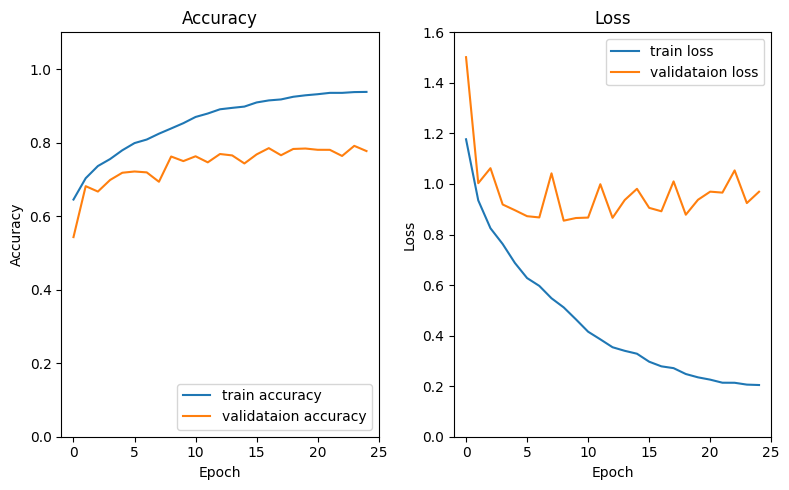

In [ ]:
# Display learning curves
display_learning_curves(history)

## Visualize Predictions

#### Inference using Colormap Overlay

The raw predictions from the model represent a one-hot encoded tensor of shape `(N, 512, 512, 20)`
where each one of the 20 channels is a binary mask corresponding to a predicted label.
In order to visualize the results, we plot them as RGB segmentation masks where each pixel
is represented by a unique color corresponding to the particular label predicted. We can easily
find the color corresponding to each label from the `human_colormap.mat` file provided as part
of the dataset. We would also plot an overlay of the RGB segmentation mask on the input image as
this further helps us to identify the different categories present in the image more intuitively.

In [ ]:
# Load the Colormap, scale its values, and convert them to integer type
colormap = loadmat("./instance-level_human_parsing/human_colormap.mat")["colormap"]
colormap = colormap * 100
colormap = colormap.astype(np.uint8)
colormap

array([[ 0,  0,  0],
       [50,  0,  0],
       [99,  0,  0],
       [ 0, 33,  0],
       [66,  0, 19],
       [99, 33,  0],
       [ 0,  0, 33],
       [ 0, 46, 86],
       [33, 33,  0],
       [ 0, 33, 33],
       [33, 19,  0],
       [20, 33, 50],
       [ 0, 50,  0],
       [ 0,  0, 99],
       [19, 66, 86],
       [ 0, 99, 99],
       [33, 99, 66],
       [66, 99, 33],
       [99, 99,  0],
       [99, 66,  0]], dtype=uint8)

In the above colomap, rows represents number of classes, and columns represent their RGB content respectively.

In [ ]:
# Create functions to infer predictions

def infer(model, image_tensor):
    # predictions from model, output shape -> (1, 512, 512, 20)
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    # Shape after squeeze -> (512, 512, 20)
    predictions = np.squeeze(predictions)
    # Select only maximum predicted value for every pixel, output shape -> (512, 512)
    predictions = np.argmax(predictions, axis=2)
    return predictions

def decode_segmentation_masks(mask, colormap, n_classes):
    # Create empty arrays for RGB values of size equal to mask
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    # For each class label, find the pixel indices where it is present and assign RGB content value for that class label using colomap
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay

def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()

def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 20)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib([image_tensor, overlay, prediction_colormap], figsize=(18, 14))

### Inference on Train Images

1/1 [==============================] - 2s 2s/step


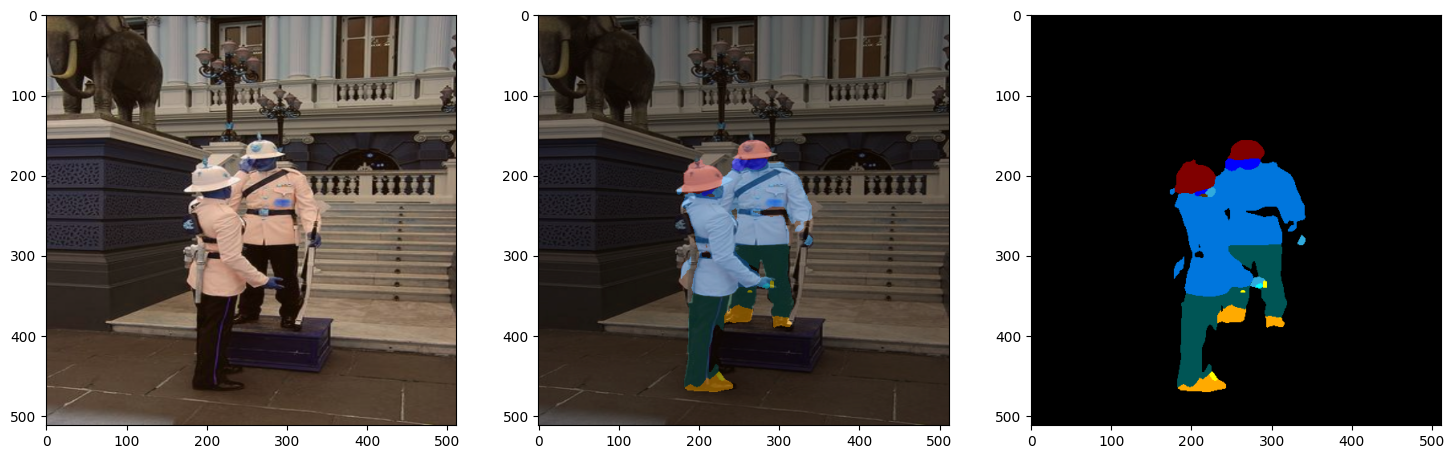

1/1 [==============================] - 0s 34ms/step


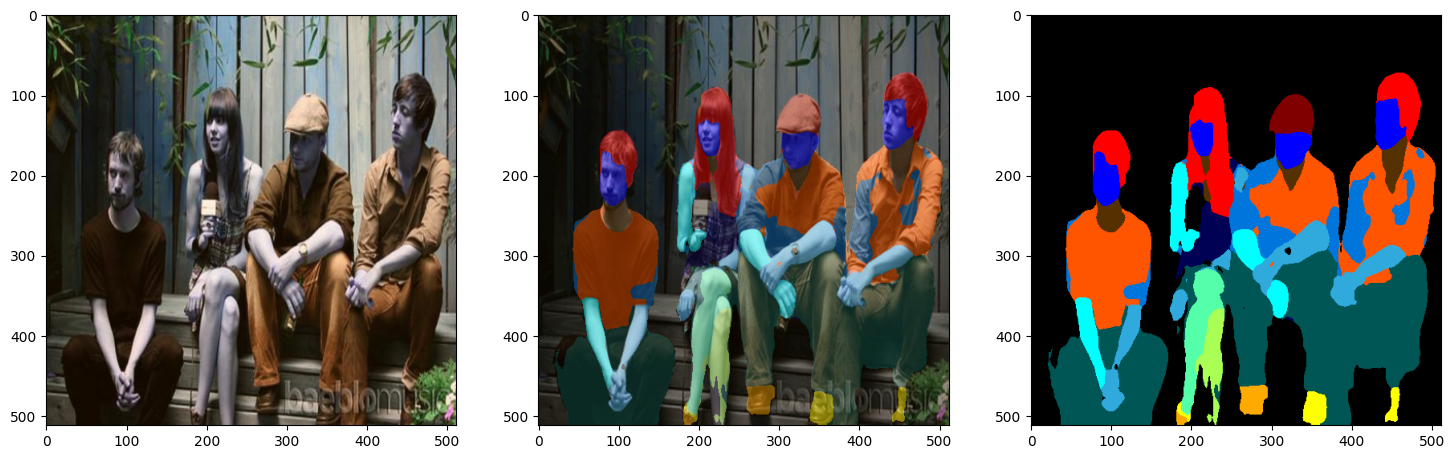

1/1 [==============================] - 0s 34ms/step


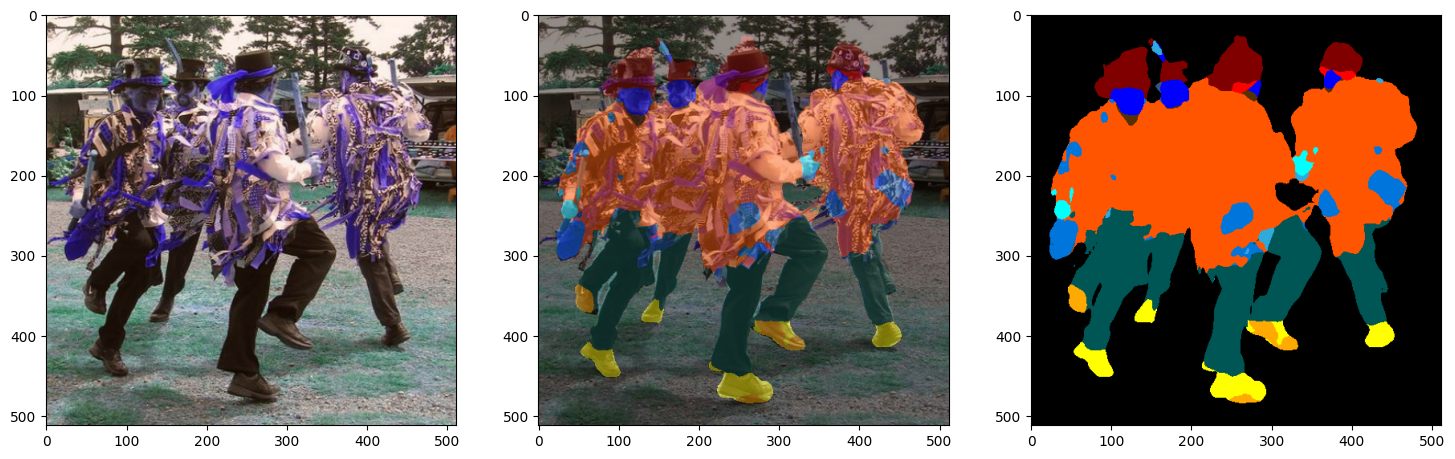

1/1 [==============================] - 0s 35ms/step


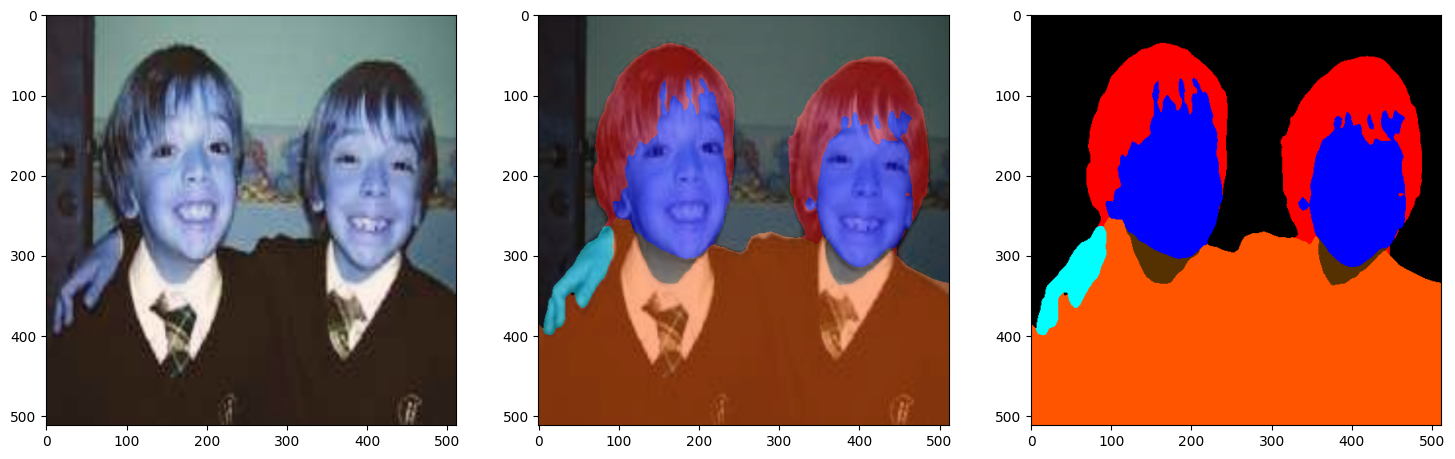

In [ ]:
plot_predictions(train_images[:4], colormap, model=model)

### Inference on Validation Images

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/deeplabv3p-resnet50) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/Human-Part-Segmentation).

1/1 [==============================] - 0s 49ms/step


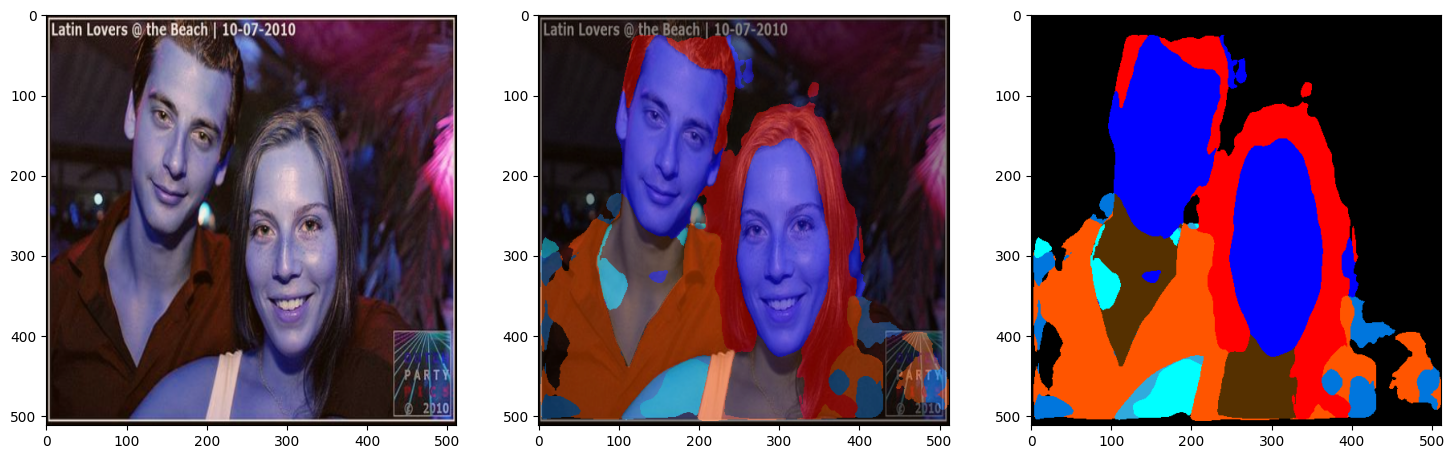

1/1 [==============================] - 0s 41ms/step


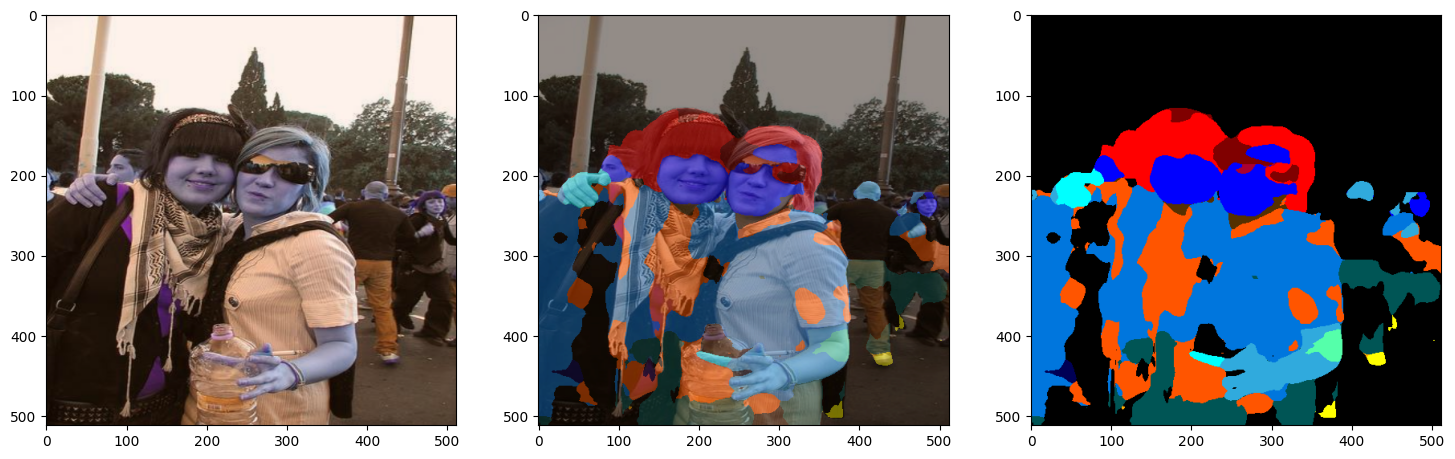

1/1 [==============================] - 0s 33ms/step


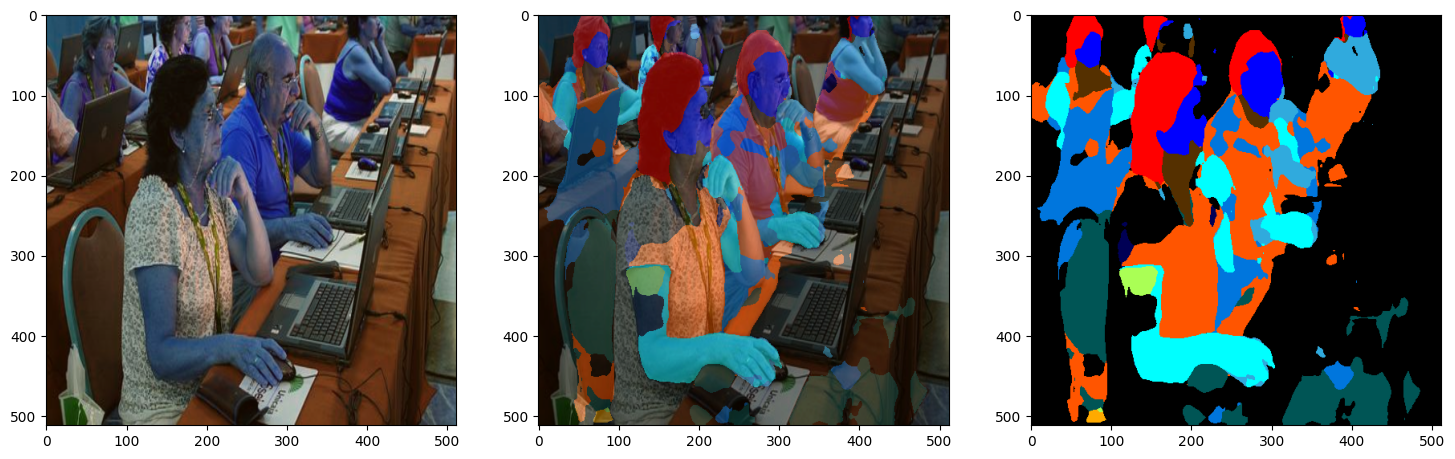

1/1 [==============================] - 0s 37ms/step


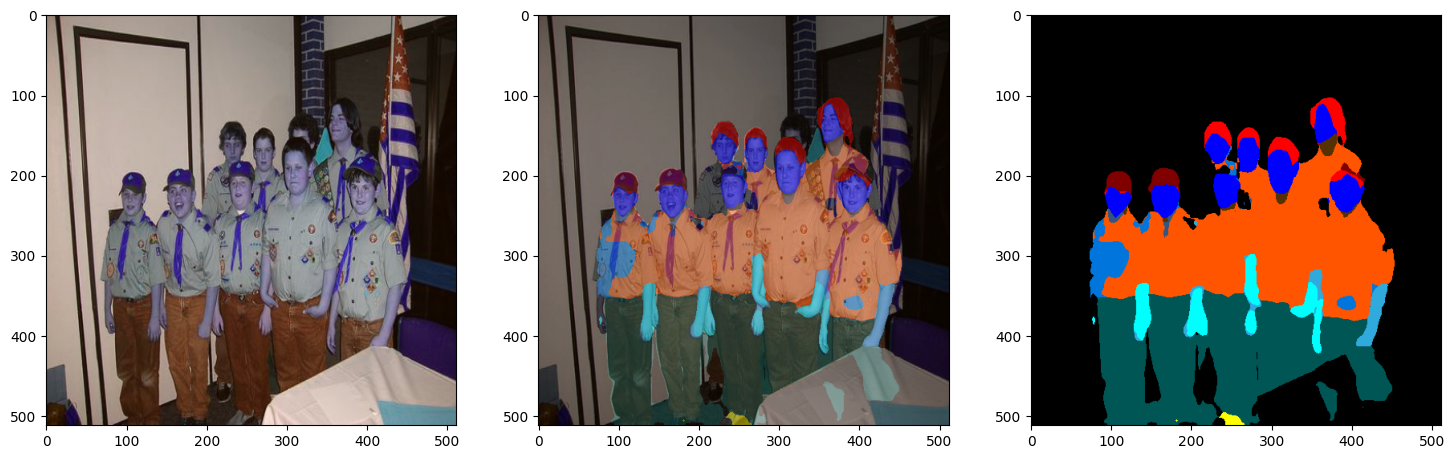

In [ ]:
plot_predictions(val_images[:4], colormap, model=model)

### References:

- [Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation](https://arxiv.org/pdf/1802.02611.pdf)
- [Rethinking Atrous Convolution for Semantic Image Segmentation](https://arxiv.org/abs/1706.05587)
- [DeepLab: Semantic Image Segmentation with Deep Convolutional Nets, Atrous Convolution, and Fully Connected CRFs](https://arxiv.org/abs/1606.00915)